In [18]:
import torch # we are going to use pytorch instead of numpy because it's much faster.
import torch.nn as nn
from ignite.contrib.metrics.regression import R2Score
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.datasets import make_spd_matrix
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as R2

In [7]:
device = torch.device("cuda")
dtype = torch.float64

# Define Scalers
*   StandardScaler
*   MinMax



In [8]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        """
        Compute the minimum and maximum value of the data for scaling.

        Args:
        - data (torch.Tensor): Input data tensor.
        """
        self.mean = torch.mean(data, dim=0, keepdim=True)
        self.std = torch.std(data, dim=0, keepdim=True)+1e-10

    def transform(self, data):
        """
        Scale the data based on the computed minimum and maximum values.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        if self.mean is None or self.std is None:
            raise ValueError("Scaler has not been fitted yet. Please call 'fit' with appropriate data.")

        scaled_data = (data - self.mean) / (self.std)
        return scaled_data

    def fit_transform(self, data):
        """
        Fit to data, then transform it.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        self.fit(data)
        return self.transform(data)

In [9]:
class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        """
        Compute the minimum and maximum value of the data for scaling.

        Args:
        - data (torch.Tensor): Input data tensor.
        """
        self.min = torch.min(data, dim=0, keepdim=True).values
        self.max = torch.max(data, dim=0, keepdim=True).values

    def transform(self, data):
        """
        Scale the data based on the computed minimum and maximum values.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted yet. Please call 'fit' with appropriate data.")

        scaled_data = (data - self.min) / (self.max - self.min)
        return scaled_data

    def fit_transform(self, data):
        """
        Fit to data, then transform it.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        self.fit(data)
        return self.transform(data)

# Define Regressors
*   Elastic Net
*   PED_SGD
*   PED_Adam
*   PED_LBFGS




In [10]:
class ElasticNet(nn.Module):
    def __init__(self, input_size, alpha=1.0, l1_ratio=0.5):
        """
        Initialize the ElasticNet regression model.

        Args:
            input_size (int): Number of input features.
            alpha (float): Regularization strength. Higher values of alpha
                emphasize L1 regularization, while lower values emphasize L2 regularization.
            l1_ratio (float): The ratio of L1 regularization to the total
                regularization (L1 + L2). It should be between 0 and 1.

        """
        super(ElasticNet, self).__init__()
        self.input_size = input_size
        self.alpha = alpha
        self.l1_ratio = l1_ratio

        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1).double()

    def forward(self, x):
        """
        Forward pass of the ElasticNet model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the ElasticNet loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The ElasticNet loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1)
        l2_reg = torch.norm(self.linear.weight, p=2)

        loss = mse_loss + self.alpha * (
            self.l1_ratio * l1_reg + (1 - self.l1_ratio) * l2_reg
        )

        return loss

    def fit(self, X, y, num_epochs=100, learning_rate=0.01):
        """
        Fit the ElasticNet model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight


In [11]:
class PED_SGD(nn.Module):
    def __init__(self, input_size, alpha=0.1):
        """
        Initialize the  regression model.


        """
        super(PED_SGD, self).__init__()
        self.input_size = input_size
        self.alpha = alpha


        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1,bias=False,device=device,dtype=dtype)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The loss.

        """
        mse_loss = nn.MSELoss(reduction='sum')(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1,dtype=torch.float64)
        l2_reg = torch.norm(self.linear.weight, p=2,dtype=torch.float64)

        loss = torch.sqrt(mse_loss) + self.alpha * (l1_reg * l2_reg)**(1/2)

        return loss

    def fit(self, X, y, num_epochs=200, learning_rate=0.01):
        """
        Fit the model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight

In [8]:
class PED_LBFGS(nn.Module):
    def __init__(self, input_size, alpha=0.1):
        """
        Initialize the  regression model.


        """
        super(PED_LBFGS, self).__init__()
        self.input_size = input_size
        self.alpha = alpha


        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1).double()

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1,dtype=torch.float64)
        l2_reg = torch.norm(self.linear.weight, p=2,dtype=torch.float64)

        loss = (len(y_true)*mse_loss)**(1/2) + self.alpha * (l1_reg * l2_reg)**(1/2)

        return loss

    def fit(self, X, y, max_iter=100, learning_rate=0.01):
        """
        Fit the model to the training data using L-BFGS optimizer.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            max_iter (int): Maximum number of optimization iterations.
            lr (float): Learning rate for the optimizer.

        """
        optimizer = optim.LBFGS(self.parameters(), lr=learning_rate, max_iter=max_iter,max_eval=10000,
                    history_size=25,
                    tolerance_grad=1e-08,
                    tolerance_change=1e-08,
                    line_search_fn="strong_wolfe")

        def closure():
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            return loss

        optimizer.step(closure)
        history = []

        for i in range(max_iter):
            loss = optimizer.step(closure)
            history.append(loss.item())
            if (i+1)%10 ==0:
              print(f"Iteration {i + 1}: Loss = {loss.item()}")

        # Print the loss values over iterations
        # print("Loss history:")
        # for i, loss in enumerate(history):
        #     print(f"Iteration {i + 1}: Loss = {loss}")


    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight

# Simulate Data

In [12]:
# we want to define a function for generating x with a prescribed number of obsvervations, features and Toeplitz correlation structure.
def make_correlated_features(num_samples,p,rho):
  vcor = [] 
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  x = np.random.multivariate_normal(mu, r, size=num_samples)
  return x

In [13]:
rho =0.9
p = 20
n = 150
vcor = []
for i in range(p):
  vcor.append(rho**i)

In [14]:
x = make_correlated_features(n,p,rho)

In [16]:
beta =np.array([-1,2,3,0,0,0,0,2,-1,4])
beta = beta.reshape(-1,1)
betas = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)

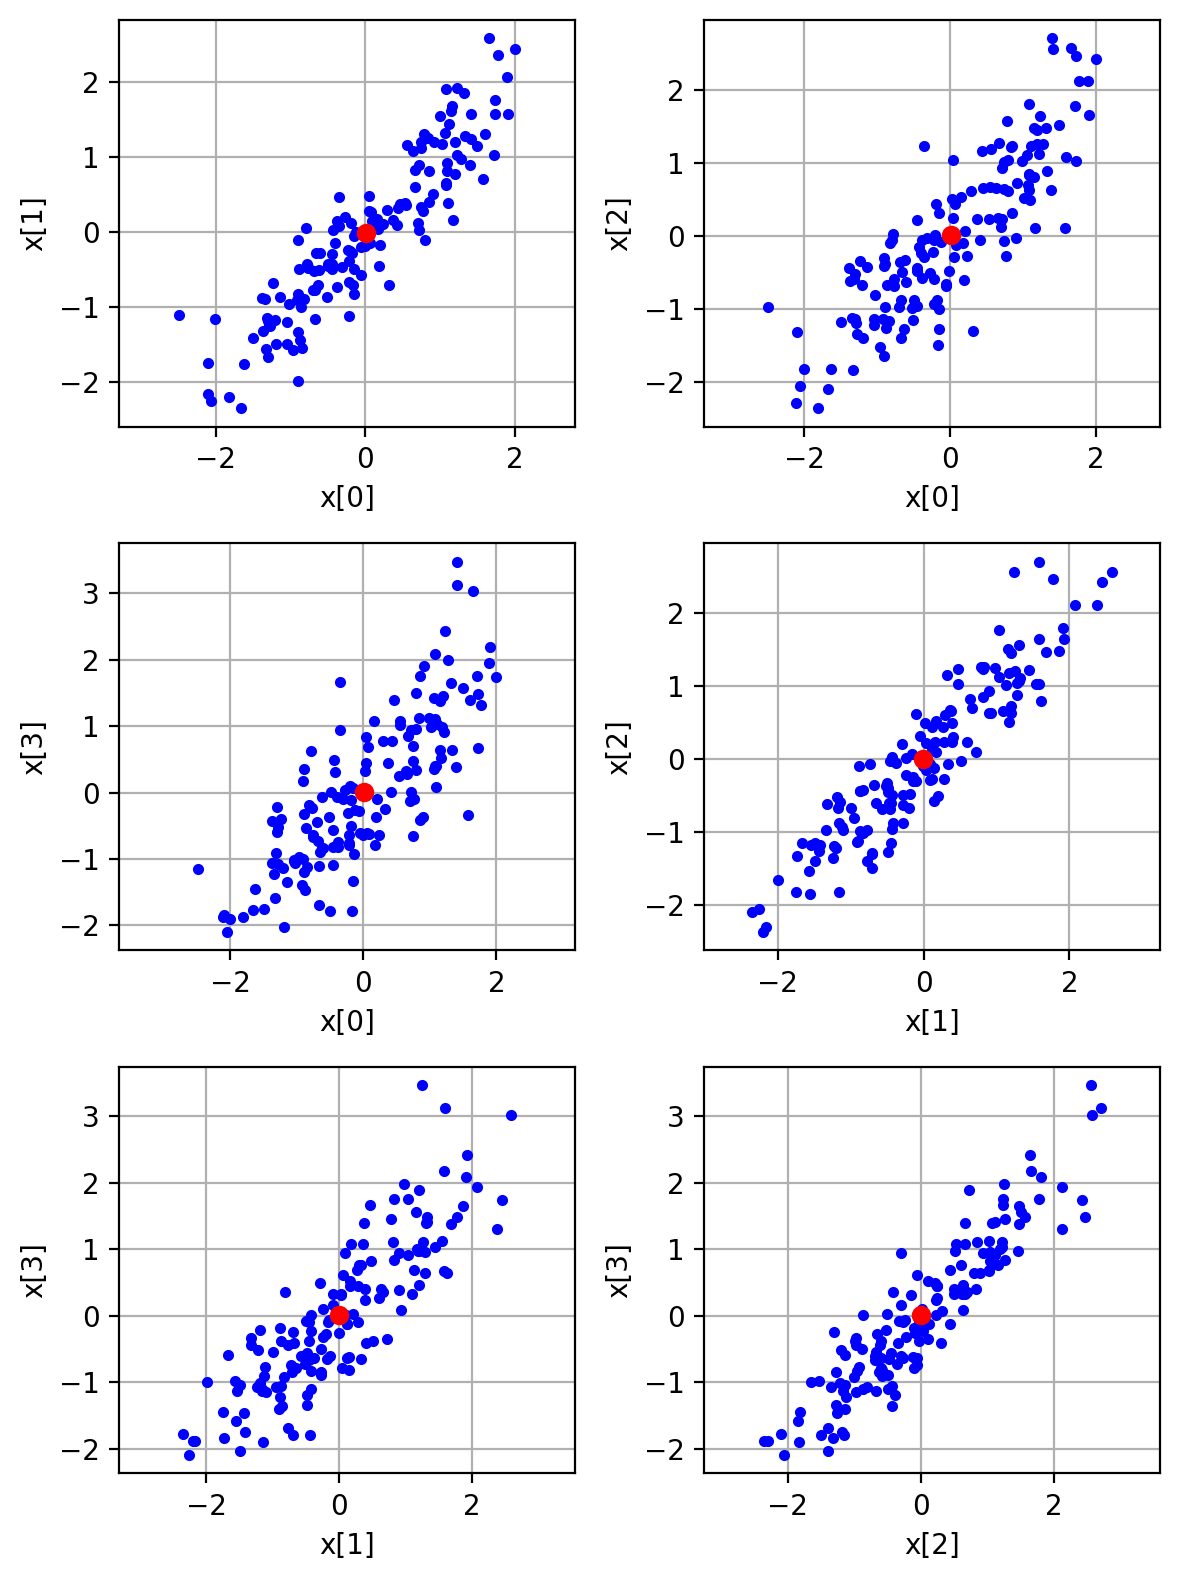

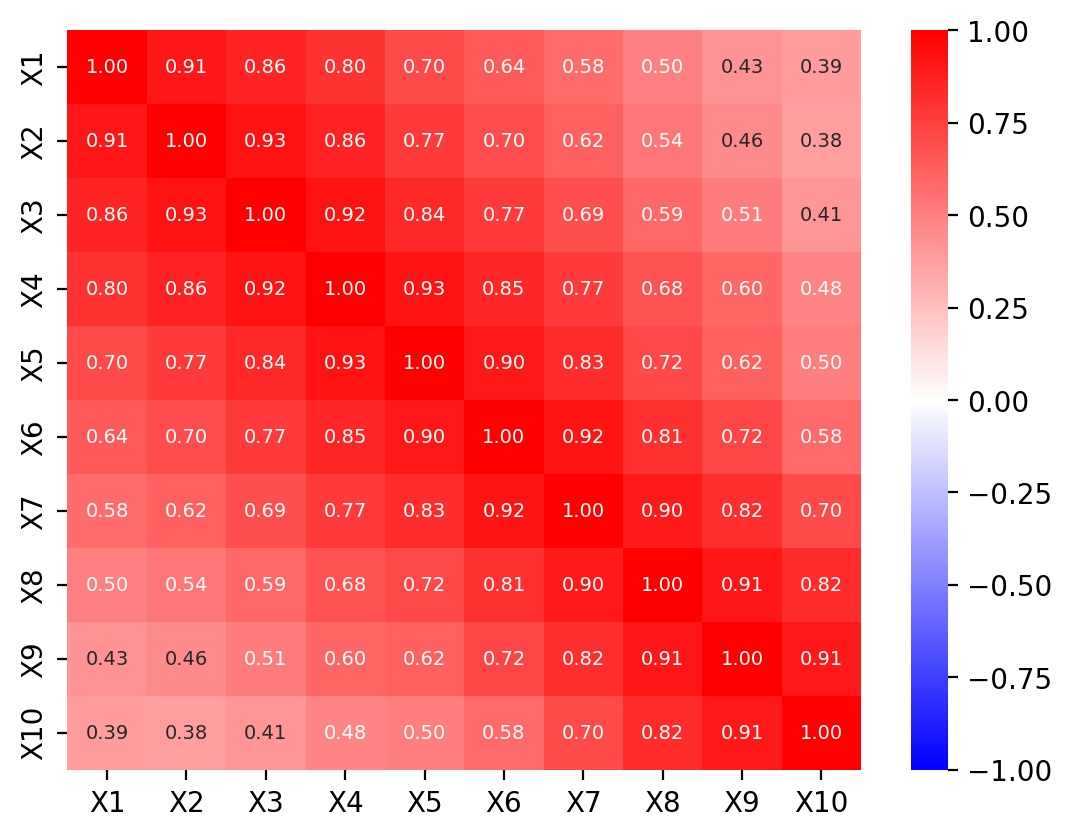

In [19]:


mu = np.mean(x,axis=0)

fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(6,8))


plt.subplot(3,2,1)
plt.plot(x[:,0], x[:,1], 'b.')
plt.plot(mu[0], mu[1], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(x[:,0], x[:,2], 'b.')
plt.plot(mu[0], mu[2], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(x[:,0], x[:,3], 'b.')
plt.plot(mu[0], mu[3], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(x[:,1], x[:,2], 'b.')
plt.plot(mu[1], mu[2], 'ro')
plt.xlabel('x[1]')
plt.ylabel('x[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(x[:,1], x[:,3], 'b.')
plt.plot(mu[1], mu[3], 'ro')
plt.xlabel('x[1]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(x[:,2], x[:,3], 'b.')
plt.plot(mu[2], mu[3
                   ], 'ro')
plt.xlabel('x[2]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)
fig.tight_layout()
plt.show()
cols = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']

# mind the transpose of x
# here we look at the correlations among the first 10 features
sns.heatmap(np.corrcoef(np.transpose(x[:,:10])),cmap='bwr',vmin=-1,vmax=1,annot=True,fmt='.2f',annot_kws={"size": 7},xticklabels=cols,yticklabels=cols)
plt.show()

In [9]:
eta = 1
t2 = [0.00177, 0.00785]
A = [0.60581, 0.39419]
p = 1000
end_time = 0.0154 # round(t2[-1]*5) # > 5 * max_T2
n = 256 #round(end_time*5/t2[0]) # end_time/n < min_T2/5
t = torch.linspace(0, end_time, n,dtype=dtype)
mean = 0
sigma = torch.tensor(0.05,dtype=dtype)

In [10]:
# Find index of eta that matches with T2 values
idx_arr = []
for t2_val in t2:
    idx_arr.append(np.round(1/t2_val/eta))
print(idx_arr)

[565.0, 127.0]


In [11]:
runs = 200 # Specify number of experiments

In [12]:
# Make design matrix X
scale = StandardScaler()
X = exp_eq(t, k = 1)
for i in range(2, p + 1):
    X = torch.column_stack((X, exp_eq(t, i)))
X = scale.fit_transform(X)/np.sqrt(len(X)-1)

In [13]:
weights = torch.zeros(p,dtype = dtype).reshape(-1,1)
weights[idx_arr] = torch.tensor(A,dtype = dtype).reshape(-1,1)

In [38]:
# Iterate experiment but perturb A with noise with every run
y = X @ weights + sigma*torch.distributions.Normal(0,1).sample((n,1))
x = X
for i in range(runs):
    output = X @ weights + sigma*torch.distributions.Normal(0,1).sample((n,1))
    y = torch.column_stack([y,output])

In [39]:
y.shape

torch.Size([256, 201])

In [40]:
x=x.to(device)
y=torch.mean(y,axis=1).to(device)
y = y.reshape(-1,1)

In [41]:
y.shape

torch.Size([256, 1])

In [30]:
x.shape

torch.Size([256, 1000])

In [206]:
print(x.size())
print(weights.size())
print(output.size())
print(output[0])

torch.Size([51456, 500])
torch.Size([1000, 1])
torch.Size([256, 1])
tensor([-0.0058], dtype=torch.float64)


# Save many simulated runs

In [16]:
df_many = pd.DataFrame({'Time': t.numpy()})

for i in range(1, runs + 1):
    output_many = X @ weights + sigma*torch.distributions.Normal(0,1).sample((n,1))
    df_many = pd.concat([df_many, pd.DataFrame({f'Run {i}': output_many.flatten().numpy()})], axis=1)
print(df_many.head())

       Time     Run 1     Run 2     Run 3     Run 4     Run 5     Run 6  \
0  0.000000  0.297313  0.201042  0.192183  0.273252  0.242268  0.209661   
1  0.000060  0.158518  0.222029  0.216048  0.169678  0.181049  0.173255   
2  0.000121  0.202853  0.155688  0.150283  0.187890  0.244827  0.157433   
3  0.000181  0.193430  0.184647  0.185942  0.145980  0.161630  0.106408   
4  0.000242  0.084911  0.113049  0.222549  0.139322  0.199002  0.173347   

      Run 7     Run 8     Run 9  ...   Run 191   Run 192   Run 193   Run 194  \
0  0.136168  0.262378  0.264922  ...  0.183909  0.208163  0.243536  0.147188   
1  0.208594  0.271658  0.172659  ...  0.236745  0.180061  0.222741  0.287939   
2  0.125394  0.194432  0.235802  ...  0.158002  0.263764  0.133104  0.256580   
3  0.248984  0.208925  0.285803  ...  0.244951  0.100253  0.219176  0.157989   
4  0.204688  0.156366  0.173457  ...  0.108015  0.199207  0.253663  0.185751   

    Run 195   Run 196   Run 197   Run 198   Run 199   Run 200  
0  0

Text(0, 0.5, 'Signal')

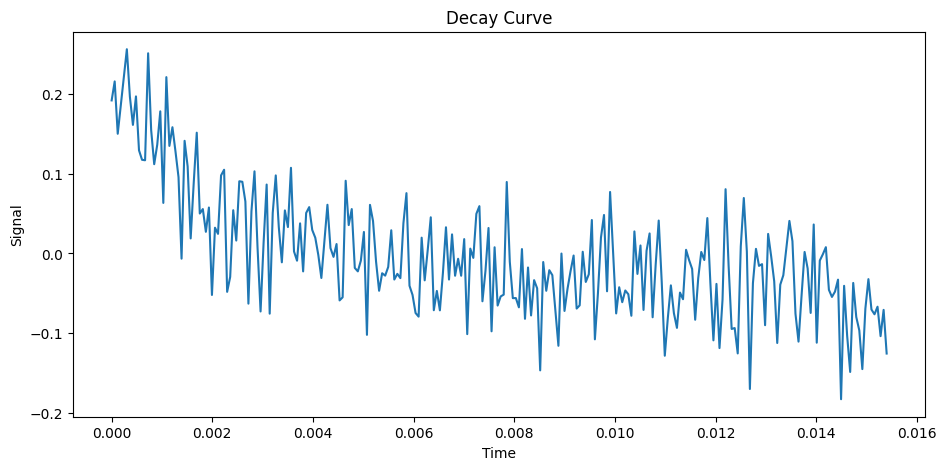

In [17]:
# Plot output
plt.plot(df_many["Time"], df_many["Run 3"])
plt.title("Decay Curve")
plt.xlabel("Time")
plt.ylabel("Signal")

In [18]:
# Save many runs as CSV
# from google.colab import files

if len(t2) == 1:
    model = "mono"
elif len(t2) == 2:
    model = "bi"
elif len(t2) == 3:
    model = "tri"
download_file_name = f"200run_{model}_W{str(A)}_T2{str(t2)}.csv"

df_many.to_csv(download_file_name, index = False)
# files.download(download_file_name)

# Test PED_SGD


In [19]:
for i in range(runs-1):
    noise_matrix = sigma*torch.distributions.Normal(0,1).sample((n,1))
    output=torch.column_stack([output,X @ weights + noise_matrix])

In [20]:
output.size()

torch.Size([256, 200])

In [48]:
alpha=1.1*norm.ppf(1-0.01/(2*p))*((p)**(1/4))/torch.sqrt(torch.tensor(n,dtype=dtype))
#alpha = 0.62

In [53]:
alpha =0.01

In [54]:
model = PED_SGD(input_size=x.shape[1],alpha = alpha)
#model = ElasticNet(input_size=x.shape[1],alpha = alpha)
model.fit(x, y, num_epochs=8000, learning_rate=0.0001)

Epoch [100/8000], Loss: 0.09073262232957449
Epoch [200/8000], Loss: 0.08933162028168672
Epoch [300/8000], Loss: 0.08910008578805682
Epoch [400/8000], Loss: 0.0888629887219801
Epoch [500/8000], Loss: 0.08861671576011447
Epoch [600/8000], Loss: 0.08836745726690846
Epoch [700/8000], Loss: 0.08811730937098351
Epoch [800/8000], Loss: 0.08786597736177157
Epoch [900/8000], Loss: 0.08761161994690654
Epoch [1000/8000], Loss: 0.0873512133402363
Epoch [1100/8000], Loss: 0.08708215821511459
Epoch [1200/8000], Loss: 0.08680124396378107
Epoch [1300/8000], Loss: 0.08650600495722698
Epoch [1400/8000], Loss: 0.08619406186894771
Epoch [1500/8000], Loss: 0.0858638321608012
Epoch [1600/8000], Loss: 0.08551366129758106
Epoch [1700/8000], Loss: 0.08514251670840053
Epoch [1800/8000], Loss: 0.0847493075115704
Epoch [1900/8000], Loss: 0.08433325662121184
Epoch [2000/8000], Loss: 0.08389322573249171
Epoch [2100/8000], Loss: 0.08342820059573713
Epoch [2200/8000], Loss: 0.08293707149469548
Epoch [2300/8000], Loss

In [55]:
betas = model.get_coefficients()[0].cpu().detach().numpy()

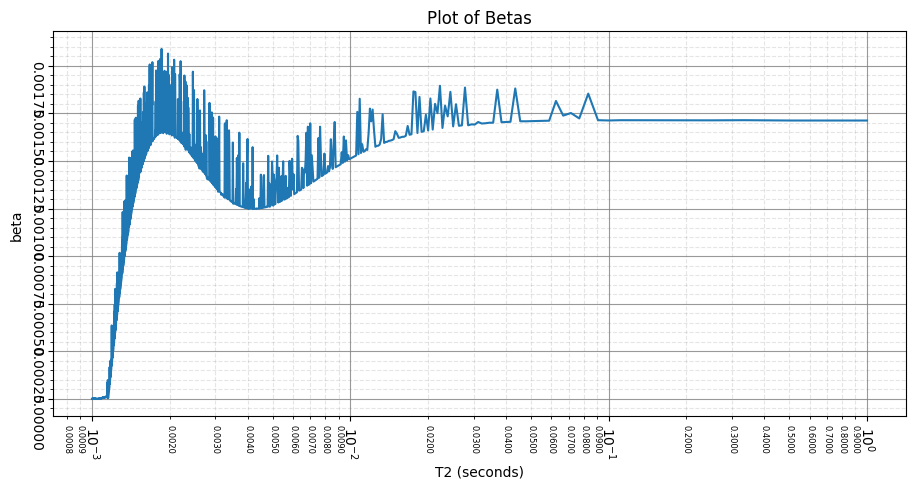

In [56]:
from matplotlib.ticker import FormatStrFormatter
t2_x_axis = [1 / (i2 * eta) for i2 in range(1, p+1)]
plt.plot(t2_x_axis, np.abs(betas))
plt.subplot(111).set_xscale('log')
plt.title("Plot of Betas")
plt.xlabel("T2 (seconds)")
plt.ylabel("beta")
plt.grid(which='major', color ='grey', linestyle='-', alpha=0.8)
plt.grid(which='minor', color ='grey', linestyle='--', alpha=0.2)
plt.minorticks_on()
axes = plt.subplot(111)
axes.xaxis.set_minor_formatter(FormatStrFormatter("%.4f"))
axes.tick_params(labelrotation=-90)
plt.setp(axes.xaxis.get_minorticklabels(), rotation=-90, fontsize = 6)
plt.show()

# Example Optimizer L-BFGS

In [ ]:
# define the Penalized Euclidean Distance objective function
#alpha=1.1*norm.ppf(1-0.01/(2*p))*((p)**(1/4))/torch.sqrt(torch.tensor(runs*n,dtype=dtype))
def f(beta):
  out = torch.norm(output[:,0]-X@beta,2)/torch.sqrt(torch.tensor(runs*n,dtype=dtype)) + alpha * torch.sqrt(torch.norm(beta,2)*torch.norm(beta,1))
  return out

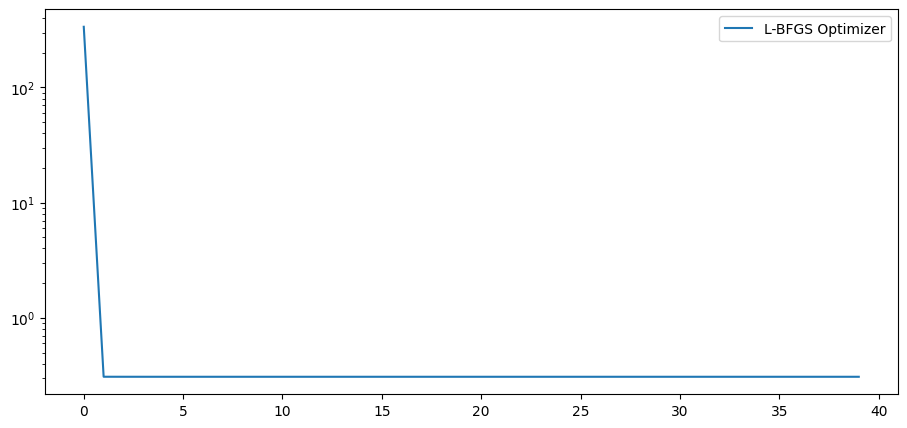

In [ ]:
# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = f(beta_lbfgs)
    objective.backward()
    return objective

beta_lbfgs = torch.ones(p, 1,dtype=dtype)
beta_lbfgs.requires_grad = True

lbfgs = optim.LBFGS([beta_lbfgs],
                    history_size=25,
                    lr=0.0001,
                    max_iter=150,
                    max_eval=10000,
                    tolerance_grad=1e-08,
                    tolerance_change=1e-08,
                    line_search_fn="strong_wolfe")

history_lbfgs = []
for i in range(40):
    history_lbfgs.append(f(beta_lbfgs).item())
    lbfgs.step(closure)


# Plotting
#plt.semilogy(history_gd, label='GD')
plt.semilogy(history_lbfgs, label='L-BFGS Optimizer')
plt.legend()
plt.show()

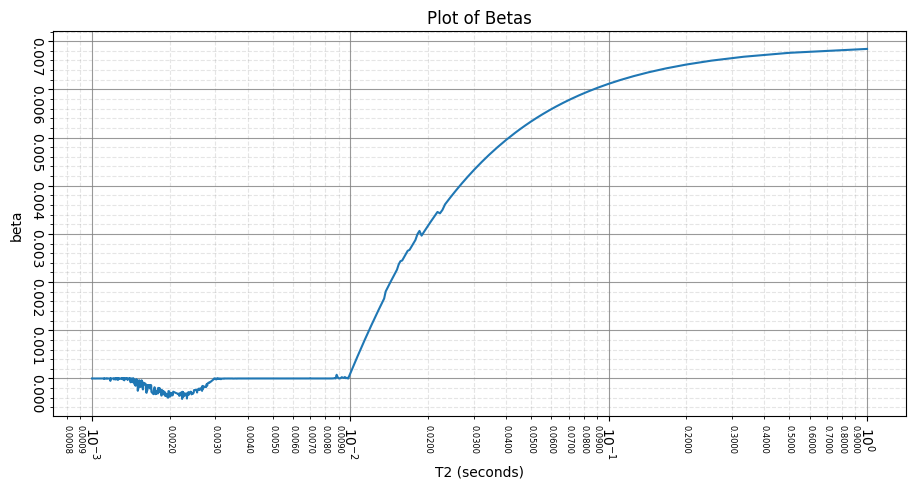

In [ ]:
from matplotlib.ticker import FormatStrFormatter
t2_x_axis = [1 / (i2 * eta) for i2 in range(1, p+1)]
plt.plot(t2_x_axis, torch.detach(beta_lbfgs).numpy())
plt.subplot(111).set_xscale('log')
plt.title("Plot of Betas")
plt.xlabel("T2 (seconds)")
plt.ylabel("beta")
plt.grid(which='major', color ='grey', linestyle='-', alpha=0.8)
plt.grid(which='minor', color ='grey', linestyle='--', alpha=0.2)
plt.minorticks_on()
axes = plt.subplot(111)
axes.xaxis.set_minor_formatter(FormatStrFormatter("%.4f"))
axes.tick_params(labelrotation=-90)
plt.setp(axes.xaxis.get_minorticklabels(), rotation=-90, fontsize = 6)
plt.show()

In [ ]:
beta_lbfgs[idx_arr]

tensor([[0.0611],
        [0.0945]], dtype=torch.float64, grad_fn=<IndexBackward0>)

In [ ]:
sum(beta_lbfgs<1e-2)/len(beta_lbfgs)


tensor([0.8100])

In [ ]:
beta_lbfgs